In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kit

In [2]:
df =pd.read_csv("healthcare-dataset-stroke-data.csv")

In [3]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
len(df)

5110

In [5]:
df = df.dropna(axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 439.3+ KB


## Working with tabular data
Deep learning with neural networks is often associated with sophisticated image recognition, and in upcoming sections we'll train models based on properties like pixels patterns and colors.

Here we're working with tabular data (spreadsheets, SQL tables, etc.) with columns of values that may or may not be relevant. As it happens, neural networks can learn to make connections we probably wouldn't have developed on our own. However, to do this we have to handle categorical values separately from continuous ones. Make sure to watch the theory lectures! You'll want to be comfortable with:
* continuous vs. categorical values
* embeddings
* batch normalization
* dropout layers

## Separate categorical from continuous columns

In [7]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'smoking_status',
       'stroke'],
      dtype='object')

In [10]:
cat_cols = ['gender','ever_married','work_type', 'Residence_type','smoking_status']
y_col = ['stroke']
cont_cols = [col for col in df.columns if col not in cat_cols + y_col]


## Categorify
Pandas offers a <a href='https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html'><strong>category dtype</strong></a> for converting categorical values to numerical codes. A dataset containing months of the year will be assigned 12 codes, one for each month. These will usually be the integers 0 to 11. Pandas replaces the column values with codes, and retains an index list of category values. In the steps ahead we'll call the categorical values "names" and the encodings "codes"

In [11]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 5110 non-null   int64   
 1   gender             5110 non-null   category
 2   age                5110 non-null   float64 
 3   hypertension       5110 non-null   int64   
 4   heart_disease      5110 non-null   int64   
 5   ever_married       5110 non-null   category
 6   work_type          5110 non-null   category
 7   Residence_type     5110 non-null   category
 8   avg_glucose_level  5110 non-null   float64 
 9   smoking_status     5110 non-null   category
 10  stroke             5110 non-null   int64   
dtypes: category(5), float64(2), int64(4)
memory usage: 265.4 KB


In [16]:
df['gender'].cat.codes.unique()

array([1, 0, 2], dtype=int8)

Now we want to combine the three categorical columns into one input array using <a href='https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html'><tt>numpy.stack</tt></a> We don't want the Series index, just the values.

In [17]:
gender = df['gender'].cat.codes.values
married = df['ever_married'].cat.codes.values
wt = df['work_type'].cat.codes.values
rt= df['Residence_type'].cat.codes.values
smoke= df['smoking_status'].cat.codes.values

In [18]:
cats = np.stack([gender,married,wt,rt,smoke],1)

# Convert numpy arrays to tensors

In [19]:
cats = torch.tensor(cats, dtype = torch.int64)

In [20]:
# Convert continuous variables to a tensor
conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)


In [21]:
# Convert labels to a tensor
# Convert labels to a tensor
y = torch.tensor(df[y_col].values).flatten()


y[:5]

tensor([1, 1, 1, 1, 1])

## Set an embedding size
The rule of thumb for determining the embedding size is to divide the number of unique entries in each column by 2, but not to exceed 50.

In [22]:
cat_szs = [len(df[col].cat.categories) for col in cat_cols]


In [23]:
emb_szs = [(size,min(50,size//2)) for size in cat_szs]

In [24]:
emb_szs

[(3, 1), (2, 1), (5, 2), (2, 1), (4, 2)]

<div class="alert alert-danger"><strong>Breaking down the embeddings steps</strong> (this code is for illustration purposes only.)</div>

In [25]:
catz = cats[:2]
catz

tensor([[1, 1, 2, 1, 1],
        [0, 1, 3, 0, 2]])

In [26]:
# This is passed in when the model is instantiated
emb_szs

[(3, 1), (2, 1), (5, 2), (2, 1), (4, 2)]

In [27]:
selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
selfembeds

ModuleList(
  (0): Embedding(3, 1)
  (1): Embedding(2, 1)
  (2): Embedding(5, 2)
  (3): Embedding(2, 1)
  (4): Embedding(4, 2)
)

In [28]:
embeddingz = []

for i,e in enumerate(selfembeds):
    embeddingz.append(e(catz[:,i]))
embeddingz

[tensor([[-1.4739],
         [ 0.8258]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.9264],
         [1.9264]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.1445,  0.0305],
         [-0.2313,  0.2443]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.6696],
         [-0.9327]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 1.3927,  0.1849],
         [-0.8182,  1.6228]], grad_fn=<EmbeddingBackward0>)]

## Define a TabularModel

In [29]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [30]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 2, [300,200], p=0.4) # out_sz = 2

In [31]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(3, 1)
    (1): Embedding(2, 1)
    (2): Embedding(5, 2)
    (3): Embedding(2, 1)
    (4): Embedding(4, 2)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=12, out_features=300, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=300, out_features=200, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=200, out_features=2, bias=True)
  )
)

## Define loss function & optimizer
For our classification we'll replace the MSE loss function with <a href='https://pytorch.org/docs/stable/nn.html#crossentropyloss'><strong><tt>torch.nn.CrossEntropyLoss()</tt></strong></a><br>
For the optimizer, we'll continue to use <a href='https://pytorch.org/docs/stable/optim.html#torch.optim.Adam'><strong><tt>torch.optim.Adam()</tt></strong></a>

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

## Perform train/test splits

In [33]:
batch_size = int(len(df))
test_size = int(len(df)*.2)

In [34]:
test_size

1022

In [35]:
cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [40]:
print('cat_train.size()',cat_train.size())
print('cat_train.ndim', cat_train.ndim)
print(cat_train[:5])

cat_train.size() torch.Size([4088, 5])
cat_train.ndim 2
tensor([[1, 1, 2, 1, 1],
        [0, 1, 3, 0, 2],
        [1, 1, 2, 0, 2],
        [0, 1, 2, 1, 3],
        [0, 1, 3, 0, 2]])


In [41]:
print('con_train.size()',con_train.size())
print('con_train.ndim', con_train.ndim)
print(con_train[:5])

con_train.size() torch.Size([4088, 5])
con_train.ndim 2
tensor([[9.0460e+03, 6.7000e+01, 0.0000e+00, 1.0000e+00, 2.2869e+02],
        [5.1676e+04, 6.1000e+01, 0.0000e+00, 0.0000e+00, 2.0221e+02],
        [3.1112e+04, 8.0000e+01, 0.0000e+00, 1.0000e+00, 1.0592e+02],
        [6.0182e+04, 4.9000e+01, 0.0000e+00, 0.0000e+00, 1.7123e+02],
        [1.6650e+03, 7.9000e+01, 1.0000e+00, 0.0000e+00, 1.7412e+02]])


## Train the model

In [36]:
import time
start_time = time.time()

epochs =500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 0.85183352
epoch:  26  loss: 0.77384675
epoch:  51  loss: 0.73964667
epoch:  76  loss: 0.72040558
epoch: 101  loss: 0.70778465
epoch: 126  loss: 0.69143981
epoch: 151  loss: 0.67810434
epoch: 176  loss: 0.66985589
epoch: 201  loss: 0.64412022
epoch: 226  loss: 0.64225870
epoch: 251  loss: 0.62807137
epoch: 276  loss: 0.62074131
epoch: 301  loss: 0.60530663
epoch: 326  loss: 0.59711361
epoch: 351  loss: 0.57664365
epoch: 376  loss: 0.56745440
epoch: 401  loss: 0.54914117
epoch: 426  loss: 0.53542763
epoch: 451  loss: 0.51767474
epoch: 476  loss: 0.49734527
epoch: 500  loss: 0.48769951

Duration: 31 seconds


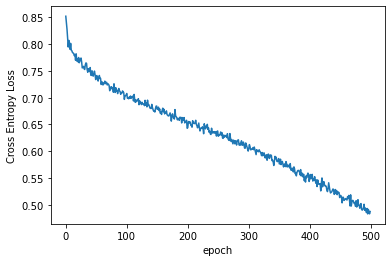

In [120]:
plt.plot(range(epochs), losses)
plt.ylabel('Cross Entropy Loss')
plt.xlabel('epoch');

In [121]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = criterion(y_val, y_test)
print(f'CE Loss: {loss:.8f}')

CE Loss: 0.48738131


In [122]:
rows = 50
correct = 0
print(f'{"MODEL OUTPUT":26} ARGMAX  Y_TEST')
for i in range(rows):
    print(f'{str(y_val[i]):26} {y_val[i].argmax():^7}{y_test[i]:^7}')
    if y_val[i].argmax().item() == y_test[i]:
        correct += 1
print(f'\n{correct} out of {rows} = {100*correct/rows:.2f}% correct')

MODEL OUTPUT               ARGMAX  Y_TEST
tensor([-0.0729,  0.1713])    1      0   
tensor([ 0.8760, -0.7349])    0      0   
tensor([ 0.3976, -0.1071])    0      0   
tensor([ 0.3624, -0.7197])    0      0   
tensor([ 0.2506, -0.7305])    0      0   
tensor([ 1.1838, -0.2646])    0      0   
tensor([-0.7949, -0.5070])    1      0   
tensor([1.9004, 0.0776])      0      0   
tensor([1.5035, 1.5681])      1      0   
tensor([-0.6873, -0.3127])    1      0   
tensor([ 0.4021, -0.6861])    0      0   
tensor([ 0.5487, -0.6342])    0      0   
tensor([ 0.4644, -0.8227])    0      0   
tensor([-0.2225, -1.0212])    0      0   
tensor([ 0.0465, -0.4539])    0      0   
tensor([-0.4253, -1.7708])    0      0   
tensor([0.0424, 0.4290])      1      0   
tensor([ 2.0346, -0.4077])    0      0   
tensor([ 0.4088, -0.5707])    0      0   
tensor([-0.6447, -0.5718])    1      0   
tensor([ 0.5384, -0.4439])    0      0   
tensor([ 0.7302, -0.9981])    0      0   
tensor([0.5214, 0.7620])      1   